In [1]:
import numpy as np
from rubin_sim.skybrightness import TwilightInterp
from rubin_scheduler.utils import _hpid2_ra_dec
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# twilight interpolation class, set to return magnitudes rather than full spectra. And I say mag, but probably mean flux
twilight = TwilightInterp(mags=True)

In [3]:
# Define some points for where we want to compute the sky brightness
# These are the coordinates that made sense to me--totally fine if there's a better system to use
names = ["sunAlt", "airmass", "azRelSun"]
types = [float]*3
points = np.zeros(1, dtype=list(zip(names,types)))

In [4]:
# Fill in. Since this usually gets called internally, all angles are in radians
points["sunAlt"] = np.radians(-17)
points["airmass"] = 1.1
points['azRelSun'] = np.radians(90.)

In [5]:
# How much flux do we exepct from the sky
flux = twilight(points, filter_names=['r'])['spec'] # return the flux per square arcsec for the given point
flux

# This is returning flux, since typically the full sky model will be adding
# this to the other sky brightness components.

array([[2.05552062e-09]])

In [6]:
# convert to AB mags per sq arcsec
mag = -2.5*np.log10(flux) + np.log10(3631.0)

In [7]:
mag

array([[25.27772165]])

In [8]:
# Let's make a grid of points on the sky
nside = 64
hpids = np.arange(hp.nside2npix(nside))
az, alt = _hpid2_ra_dec(nside,hpids) # leading underscoe means this is returning radians

In [9]:
# array of points to compute background at
points = np.zeros(hpids.size, dtype=list(zip(names,types)))

In [10]:
# equuation for converting altitude to airmass
points["airmass"] = 1.0 / np.cos(np.pi / 2.0 - alt)

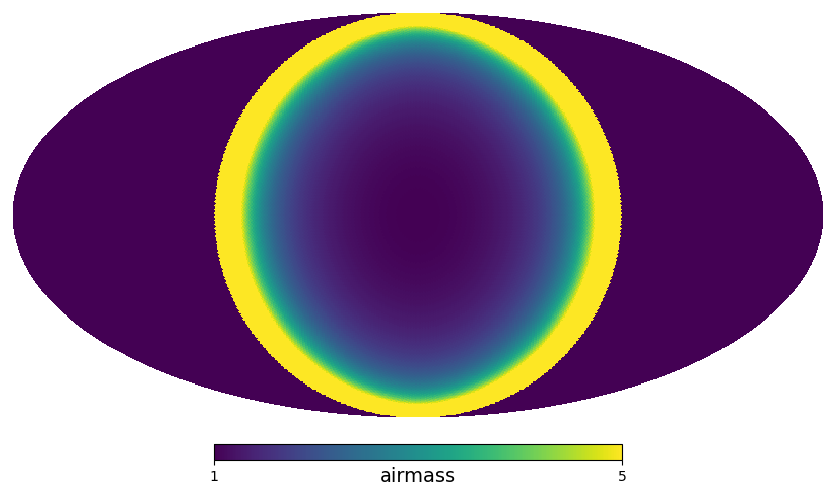

In [11]:
# Make sure we have the airmass right. Rotated so zenith is in the center.
hp.mollview(points["airmass"], max=5, min=1, rot=(0,90,0), title="", unit="airmass")

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_9326/1534510971.py:8: RuntimeWarning: divide by zero encountered in log10
  mag = -2.5*np.log10(flux) + np.log10(3631.0) # convert to AB mags per sq arcsec


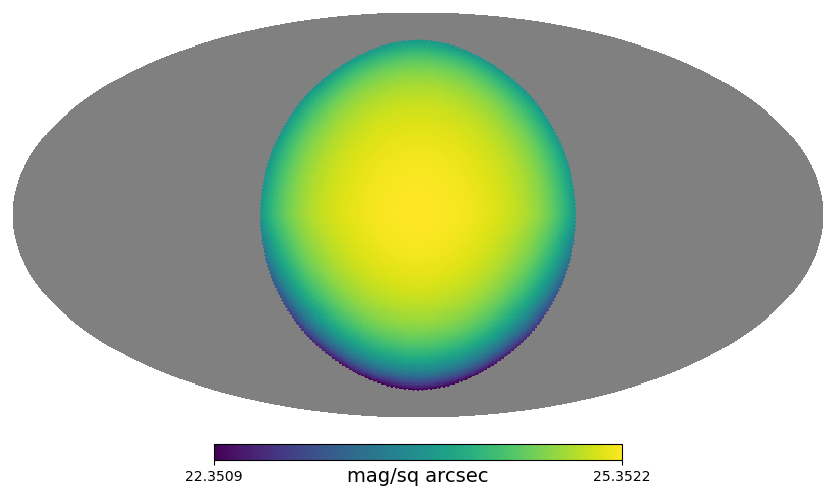

In [12]:
# 
points["azRelSun"] = az
points["sunAlt"] = np.radians(-17)

# Compute flux and mag for all our points.
# Could do multiple filters if we wanted to.
flux = twilight(points, filter_names=['r'])['spec'] # return the flux per square arcsec for the given point
mag = -2.5*np.log10(flux) + np.log10(3631.0) # convert to AB mags per sq arcsec

# mask off low altitude values
mag[np.where(alt < np.radians(20))] = np.nan

# Zenith at center. Looks like the az of the sun is at the bottom.
hp.mollview(np.ravel(mag), rot=(0,90,0), unit='mag/sq arcsec', title='')

The `TwilightInterp` class has a bunch of hard-coded fit results, which in turn are used to calls `twilight_func`. 

But this is shows what can plug easily into the full sky model--a callable object that takes airmass, sun altitude, and azimuth relative to the sun and returns the expected sky flux.

One possibility might be to add a parameter to `twilight_func` that is something like a second brightening slope, then have that kick in when sunAlt is above some threshold. 